In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime
from torch.utils.data import TensorDataset, DataLoader

In [2]:
st = read("/home/sysop/pytorch/Data/0121Dapu.mseed")
t1 = UTCDateTime(2025, 1, 20, 16, 17, 16)
t2 = UTCDateTime(2025, 1, 20, 16, 17, 34)
st2 = st.slice(t2, t2+5)

st2.normalize()
st2.detrend()

201 Trace(s) in Stream:

TW.ALS.10.HLE | 2025-01-20T16:17:34.000000Z - 2025-01-20T16:17:39.000000Z | 100.0 Hz, 501 samples
...
(199 other traces)
...
TW.YUS.10.HLZ | 2025-01-20T16:17:34.000000Z - 2025-01-20T16:17:39.000000Z | 100.0 Hz, 501 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [3]:
X_train = torch.tensor(np.array([i.data for i in st2[:129]]))
Y_train = torch.tensor(np.array([1 if i.stats.station in ["ALS", "CHN8", "CHY", "SCL", "ELD"] else 0 for i in st2[:129]]))
X_test = torch.tensor(np.array([i.data for i in st2[129:]]))
Y_test = torch.tensor(np.array([1 if i.stats.station in ["SSD", "TAI", "TAI1", "WDL", "WGK", "WSF", "YUS"] else 0 for i in st2[129:]]))

train_data = DataLoader(TensorDataset(X_train, Y_train), batch_size = 3, shuffle = True)
test_data = DataLoader(TensorDataset(X_test, Y_test), batch_size = 3, shuffle =True)

### Dataloader Display

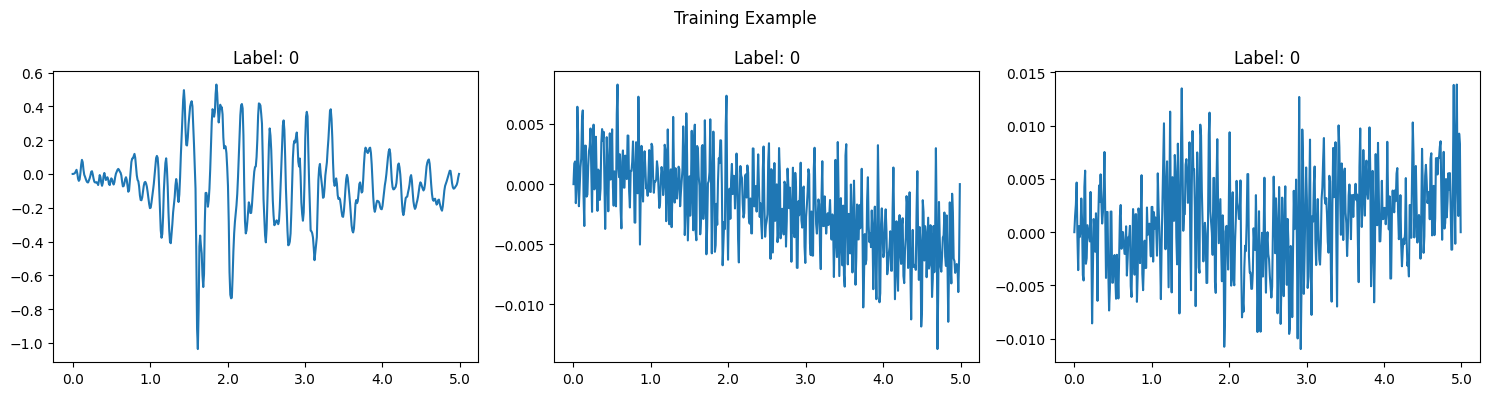

In [10]:
train_features, train_labels = next(iter(train_data))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):   
    data = train_features[i]
    label = train_labels[i]
    axes[i].plot(data.numpy())
    axes[i].set_title(f"Label: {label}")
    axes[i].set_xticks(np.linspace(0, 501, 6), np.linspace(0, 5, 6))

fig.suptitle("Training Example")
plt.tight_layout()
plt.savefig("train_result.png", dpi = 300)
plt.show()

### Module

In [6]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(501, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
        )
    def forward(self, x):
        return self.net(x)

In [15]:
class Simple1DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(501, 10, kernel_size=7, padding=3)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(10, 2, kernel_size=5, padding=2)
        # self.fc1 = nn.Linear(32 * (input_length // 4), 64)
        # self.fc2 = nn.Linear(64, num_classes)  # softmax or sigmoid

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

### Training

In [16]:
train_losses = []
train_accuracies = []

# model = FNN()
model = Simple1DCNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

for epoch in range(500):
    correct = 0
    total = 0
    running_loss = 0.0
    
    for xb, yb in train_data:
        xb = xb.float()
        out = model(xb)
        loss = loss_fn(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        pred = out.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
        
    avg_loss = running_loss / total
    acc = correct / total    
    train_losses.append(avg_loss)
    train_accuracies.append(acc)
    
    if (epoch + 1) % 50 == 0:
            print(f'epoch: {epoch+1}, loss = {loss.item(): .4f}')

RuntimeError: Given groups=1, weight of size [10, 501, 7], expected input[1, 3, 501] to have 501 channels, but got 3 channels instead

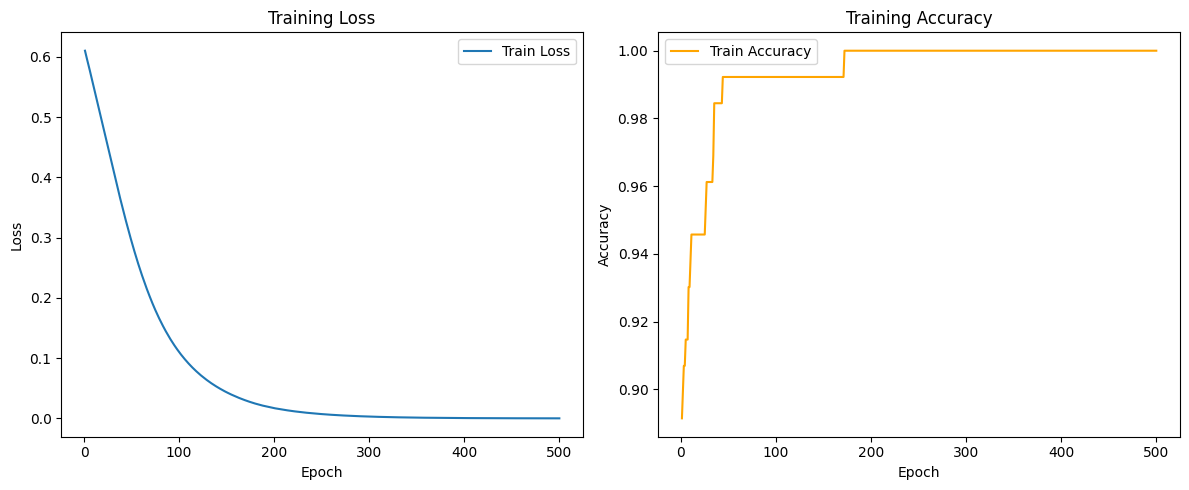

In [9]:
epochs_range = range(1, len(train_losses)+1)

plt.figure(figsize=(12, 5))

# Loss 
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Accuracy 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("training_progress.png", dpi=300)
plt.show()

### Testing data

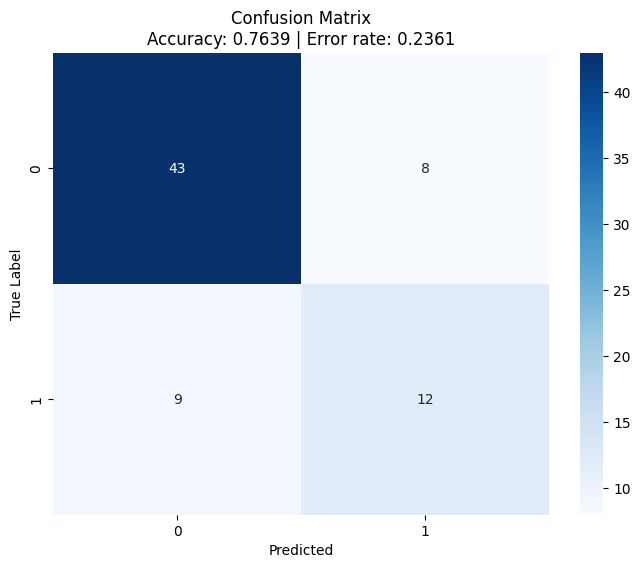

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
all_preds = []
all_labels = []


with torch.no_grad():
    for xb, yb in test_data:
        xb = xb.float()
        pred = model(xb).argmax(1)        
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
total = cm.sum()
correct = np.trace(cm)
incorrect = total - correct

accuracy = correct / total
error_rate = incorrect / total

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix\nAccuracy: {accuracy:.4f} | Error rate: {error_rate:.4f}")
plt.savefig("Confusion_Matrix", dpi = 300)
plt.show()

In [9]:
import torch

model.eval()
all_preds = []
all_labels = []
all_indices = []

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_data):
        inputs = inputs.float()
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.append(preds)
        all_labels.append(labels)
        
        # 如果想記錄全局資料索引，需要事先準備索引或用 batch_size 計算
        # 假設 test_loader 不打亂且 batch_size 一定，可以用以下方式計算索引
        start_idx = batch_idx * test_data.batch_size
        batch_indices = torch.arange(start_idx, start_idx + inputs.size(0))
        all_indices.append(batch_indices)

# 合併所有 batch 的結果
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
all_indices = torch.cat(all_indices)

# 找出判斷錯誤的資料索引
wrong_mask = (all_preds != all_labels)
wrong_indices = all_indices[wrong_mask]
wrong_preds = all_preds[wrong_mask]
wrong_labels = all_labels[wrong_mask]

print(f"錯誤樣本數量: {wrong_indices.size(0)}")
print("錯誤樣本的全局索引:", wrong_indices)
print("錯誤樣本的預測結果:", wrong_preds)
print("錯誤樣本的真實標籤:", wrong_labels)


錯誤樣本數量: 19
錯誤樣本的全局索引: tensor([ 1,  2,  4, 11, 12, 22, 27, 29, 32, 33, 35, 37, 39, 45, 49, 50, 61, 65,
        69])
錯誤樣本的預測結果: tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0])
錯誤樣本的真實標籤: tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1])
